## **Forecasting Bitcoin Prices via ARIMA and LSTM**

# **Introduction**

Cryptocurrencies, especially **Bitcoin**, have gained global attention due to their increasing adoption by individuals, institutions, and even governments. However, Bitcoin's extreme **price volatility** makes it a challenging asset to predict accurately. Reliable forecasting of Bitcoin prices could significantly benefit investors, traders, and analysts in making informed decisions.

In this project, we evaluate the forecasting performance of two widely used **time series models**:

**ARIMA (AutoRegressive Integrated Moving Average)** **:** a statistical model known for linear trend analysis.

**LSTM (Long Short-Term Memory)** **:** a deep learning model designed to capture nonlinear patterns and long-term dependencies in sequential data.

By splitting the Bitcoin price data into **training (70%) and testing (30%)** sets, we train each model on historical prices and assess their performance on unseen data. **The Root Mean Squared Error (RMSE)** is used as the main evaluation metric to determine which model performs better.



# **Problem Statement**

Bitcoin prices are highly volatile and difficult to predict using traditional methods. The goal of this study is to:

**Compare the predictive accuracy of ARIMA and LSTM models in forecasting Bitcoin prices, using RMSE as the evaluation metric, and determine which model is more effective for time series prediction in a volatile financial context.**



# **Resources:**


**1)LSTM :** https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/


**2)Kaggle :**  https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data


3)We referred to the lab manual for Exploratory Data Analysis (EDA) and ARIMA parameter tuning, specifically for:
  ACF and PACF interpretation
  Stationarity checks
  Differencing techniques

**1. Exploratory Data Analysis**

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.plotting import autocorrelation_plot

In [ ]:
# read the dataset into a dataframe
df = pd.read_csv('/content/btcusd_1-min_data.csv')
df.head()

,Timestamp,Open,High,Low,Close,Volume,datetime
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:01:00+00:00
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:02:00+00:00
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:03:00+00:00
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:04:00+00:00
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:05:00+00:00


In [ ]:
# Here we start cleaning the data. Firstly, converting Timestamp to datetime64
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')
# sets the index as the date
df.index = df.Timestamp
# Resamples the data to the average daily value of each column. Removes excessive frequency
# Explicitly selecting numeric columns for the mean calculation
numeric_cols = df.select_dtypes(include=np.number).columns
df = df[numeric_cols].resample('D').mean()
#drops any missing values that are present
df = df.dropna()

In [ ]:
df.head()

,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-01,4.645697,4.645697,4.645697,4.645697,0.011919
2012-01-02,4.975000,4.975000,4.975000,4.975000,0.007014
2012-01-03,5.085500,5.085500,5.085500,5.085500,0.074365
2012-01-04,5.170250,5.170396,5.170250,5.170396,0.074468
2012-01-05,5.954292,5.954361,5.954292,5.954361,0.048839


In [ ]:
print(df.shape)

(4825, 5)


**Seasonal Decompose**

<Figure size 1200x800 with 0 Axes>

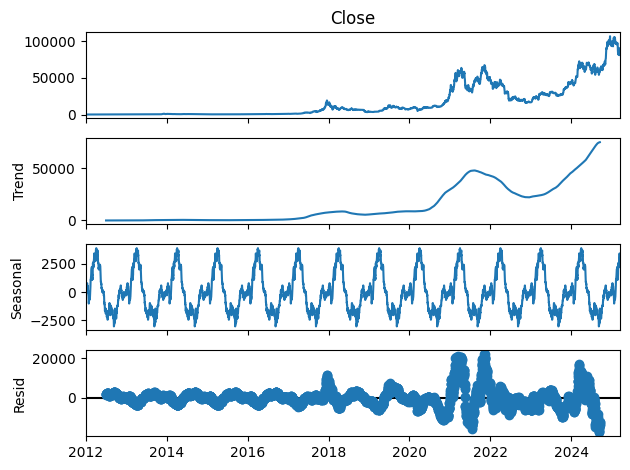

In [ ]:

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Close'], model='additive', period=365)

# Plot the decomposition
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.show()

The image shows the time series decomposition of Bitcoin's closing price into trend, seasonal, and residual components:
1. Observed (Close): The original Bitcoin price trend, showing a sharp increase after 2020.
2. Trend: A smoothed version indicating long-term upward movement, especially after 2020.
3. Seasonal: Repeating short-term uctuations, indicating yearly cyclical patterns.
4. Residual: The remaining variation after removing trend and seasonality, showing higher volatility around 2021-2022.
This decomposition helps in understanding price movements and forecasting future trends.

<Figure size 1200x800 with 0 Axes>

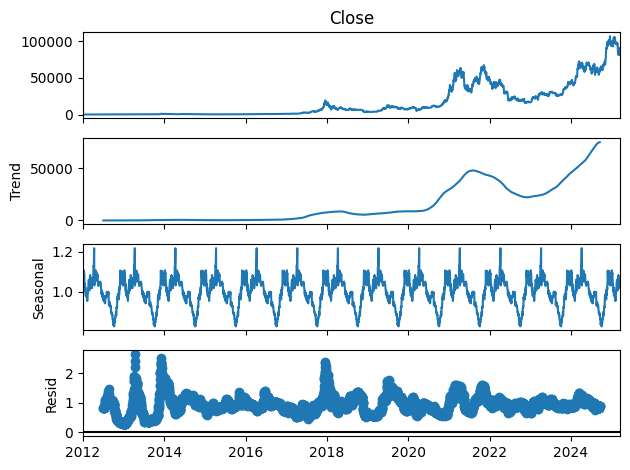

In [ ]:

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Close'], model='multiplicative', period=365)

# Plot the decomposition
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.show()

This image also represents the time series decomposition of Bitcoin's closing price:
1. Observed (Close): The original price series showing strong growth after 2020.
2. Trend: A smooth upward trend, indicating long-term price appreciation.
3. Seasonal: Regular uctuations, likely due to recurring market cycles.
4. Residual: Remaining noise after removing trend and seasonality, showing high volatility before 2016 and around 2021.
The key difference from the previous image is the seasonal component's scale, which appears normalized, possibly due to a multiplicative
decomposition instead of an additive one.


In [ ]:
df["Weighted_Price"] = (df["Close"] * df["Volume"]) / df["Volume"]

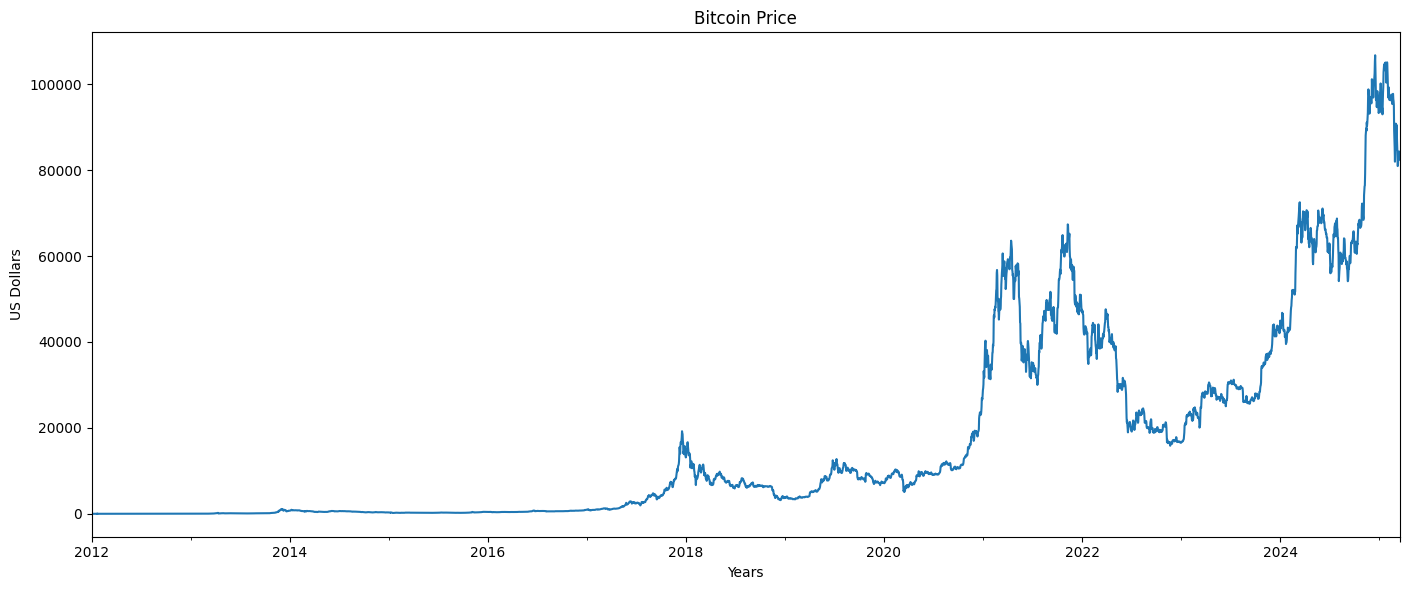

In [ ]:
df.Weighted_Price.plot(title = "Bitcoin Price", figsize=(14,6))
plt.tight_layout()
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.show()

This image represents the historical price trend of Bitcoin over time:
1. Exponential Growth: Bitcoin's price remained low until around 2017, after which it experienced rapid growth.
2. Volatility: There are multiple peaks and crashes, notably in 2018, 2021, and 2024, indicating highly volatile market behavior.
3. Recent Surge: A sharp price increase is seen after 2023, reaching over $100,000 before a slight decline.
4. Market Cycles: The chart suggests repetitive boom-and-bust cycles, characteristic of Bitcoin’s speculative nature.
This visualization is useful for understanding long-term trends and price uctuations in Bitcoin.


**#Stationality**

In [ ]:
 # Check the stationarity
 #Null Hypothesis (H₀): The time series has a unit root (i.e., it is non-stationary).
 #Alternate Hypothesis (H₁): The time series does not have a unit root (i.e., it is stationary).
 # p-value > 0.05 → Fail to reject H₀ (Series is non-stationary).

from statsmodels.tsa.stattools import adfuller
print("Result of ADF test:")
dftest= adfuller(df['Close'])
dfoutput = pd.Series(dftest[0:4], index=['Test Stats','p-value','#lags used','Number of Observations Used'])
for key,value in dftest[4].items():
  dfoutput['Critical value(%s)' %key]= value
print(dfoutput)


Result of ADF test:
Test Stats                       -0.661695
p-value                           0.856423
#lags used                       31.000000
Number of Observations Used    4793.000000
Critical value(1%)               -3.431715
Critical value(5%)               -2.862143
Critical value(10%)              -2.567091
dtype: float64


Interpretation of Output
p-value = 0.856423 (>> 0.05) → Fail to reject H₀ → The Bitcoin price series is non-stationary.

In [ ]:
 #Null Hypothesis (H₀): The time series is stationary.
 #Alternative Hypothesis (H₁): The time series is non-stationary (has a unit root).
 #p-value > 0.05 → Fail to reject H₀ → Series is stationary.

from statsmodels.tsa.stattools import kpss
kp = kpss(df['Close'])
p=kp[1]
print("p-value of kpss test",p)

p-value of kpss test 0.01


<ipython-input-11-21323e4c2390>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kp = kpss(df['Close'])


The p-value = 0.01 (or smaller) is ≤ 0.05.
This means we reject H₀ → The Bitcoin price series is non-stationary.

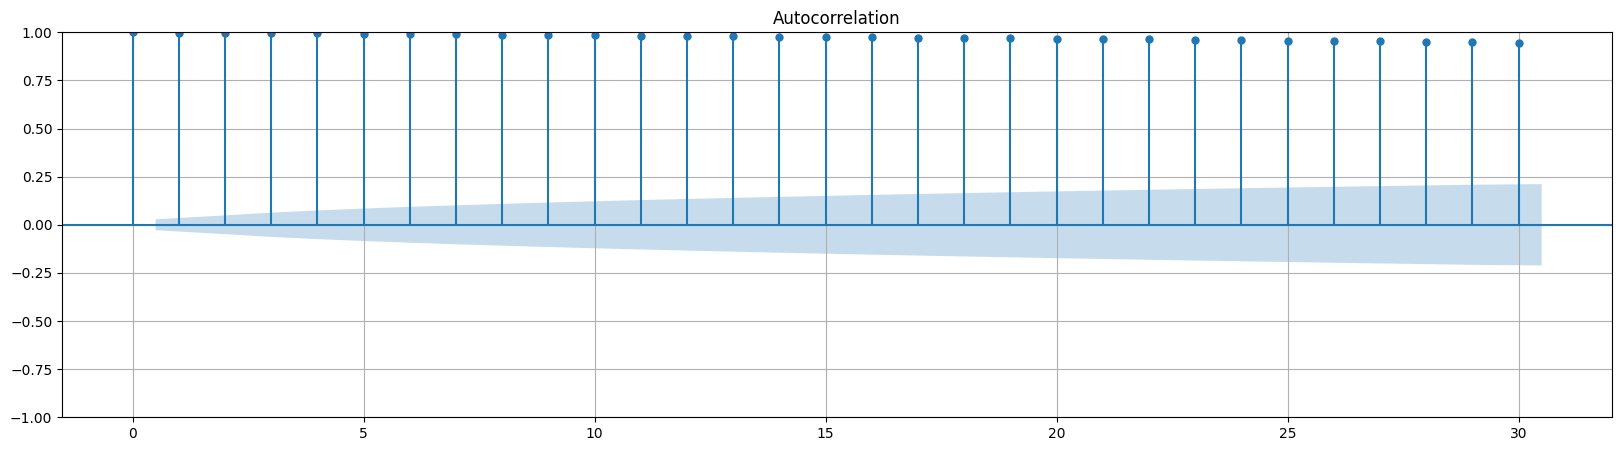

In [ ]:
# acf and pacf
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plt.figure(figsize=(20,5))
plt.grid()
plot_acf(df['Close'], ax=plt.gca(),lags=30)
plt.show()

High Autocorrelation at All Lags

Non-Stationarity

Need for Differencing

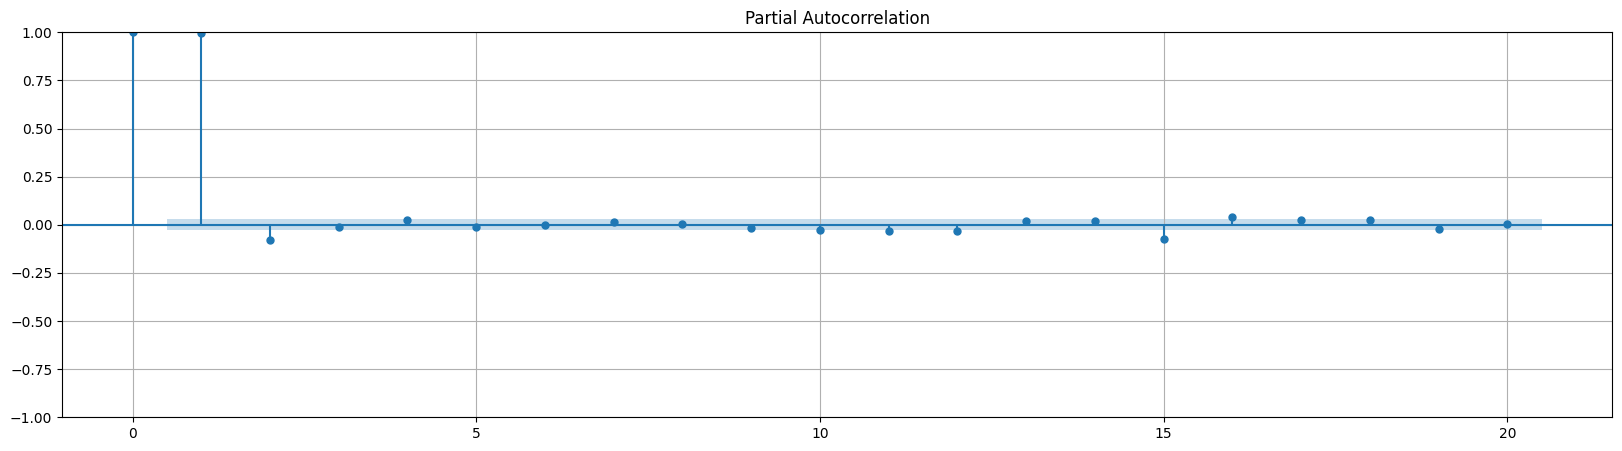

In [ ]:
plt.figure(figsize=(20,5))
plt.grid()
plot_pacf(df['Close'], ax=plt.gca(),lags=20)
plt.show()

Signicant Spike at Lag 1

All Other Lags Are Within the Condence Interval

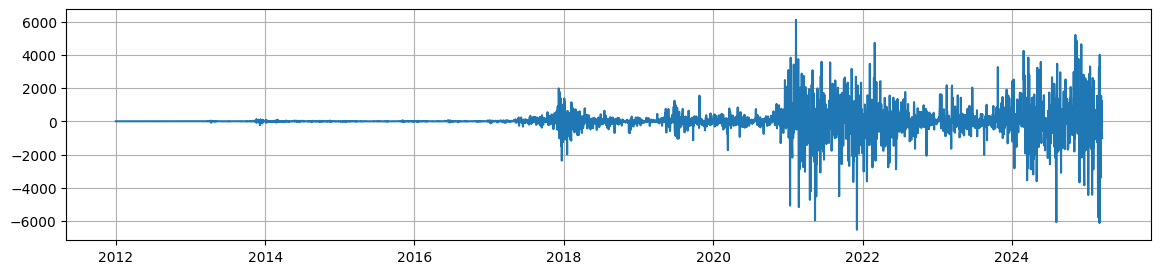

In [ ]:
# First order differencing
diff=df['Close'].diff().dropna()
plt.figure(figsize=(14,3))
plt.grid()
plt.plot(diff)
plt.show()

Increased Variability Over Time

Mean Reversion Around Zero: The differenced series uctuates around zero, suggesting that the trend component has been removed

In [ ]:
#Now check the stationarity and for that run adf, kpss, and acf plot again
#Now check the stationarity and for that run adf, kpss, and acf plot again
#Null Hypothesis (H₀): The time series has a unit root (i.e., it is non-stationary).
#Alternative Hypothesis (H₁): The time series does not have a unit root (i.e., it is stationary).

from statsmodels.tsa.stattools import adfuller
print("Result of ADF test:")
dftest= adfuller(df['Close'])
dfoutput = pd.Series(dftest[0:4], index=['Test Stats','p-value','#lags used','Number of Observations Used'])
for key,value in dftest[4].items():
  dfoutput['Critical value(%s)' %key]= value
print(dfoutput)


Result of ADF test:
Test Stats                       -0.661695
p-value                           0.856423
#lags used                       31.000000
Number of Observations Used    4793.000000
Critical value(1%)               -3.431715
Critical value(5%)               -2.862143
Critical value(10%)              -2.567091
dtype: float64


p-value = 0.856423 (which is much higher than 0.05).
We fail to reject H₀, meaning the time series is non-stationary.

In [ ]:
from statsmodels.tsa.stattools import kpss
kp = kpss(df['Close'])
p=kp[1]
print("p-value of kpss test",p)

p-value of kpss test 0.01


<ipython-input-16-21323e4c2390>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kp = kpss(df['Close'])


p-value = 0.01 (which is less than 0.05).

We reject H₀, meaning the time series is non-stationary.


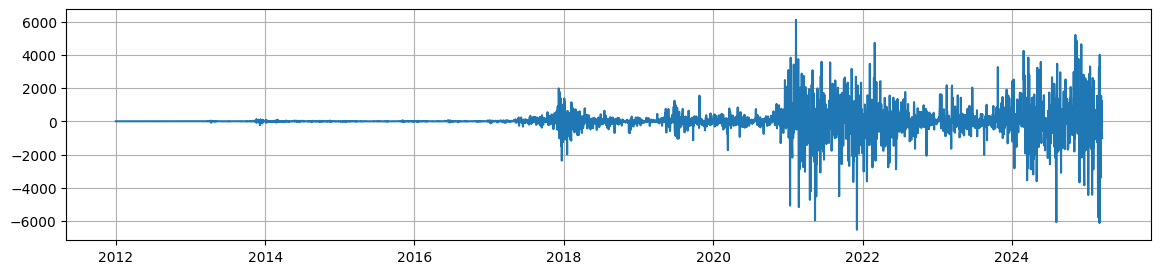

In [ ]:
# second order diffrencing
diff2=df['Close'].diff().diff().dropna()
plt.figure(figsize=(14,3))
plt.grid()
plt.plot(diff)
plt.show()

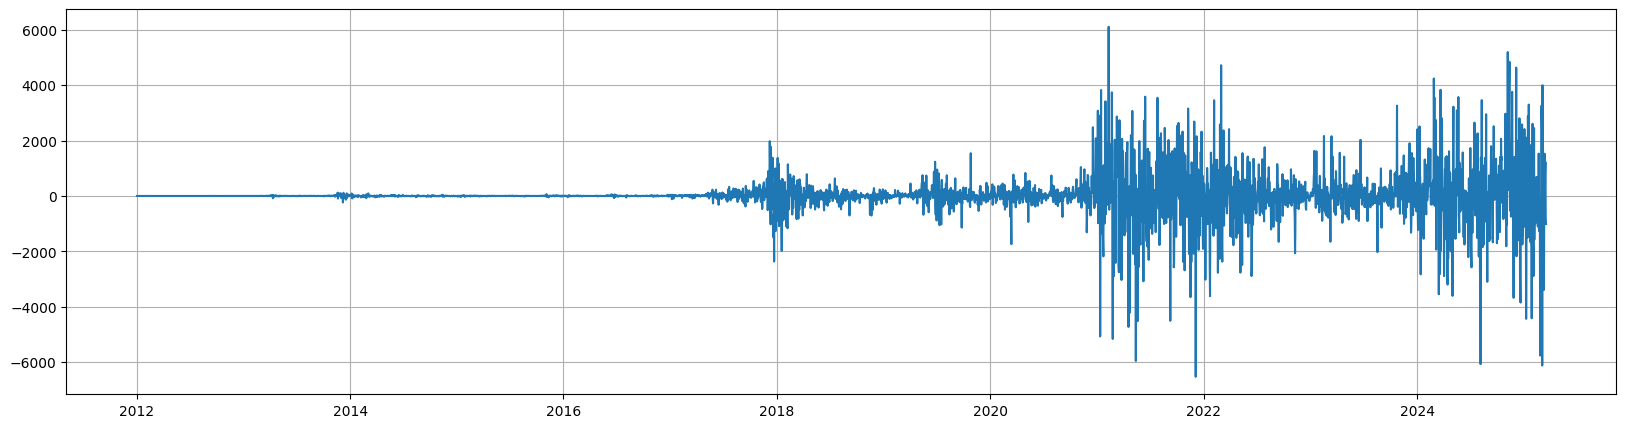

In [ ]:
# 3rd order non seasonal - differencing
diff3=df['Close'].diff().diff().diff().dropna()
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(diff)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
print("Result of Dickey Fuller Test")
dftest=adfuller(diff3)
dfoutput=pd.Series(dftest[0:4],index=["Test Statistic","p-value",'#Lags used','Number of Observation'])
for key,value in dftest[4].items():
    dfoutput['Critical Value(%s)' %key]= value
print(dfoutput)

Result of Dickey Fuller Test
Test Statistic            -28.433009
p-value                     0.000000
#Lags used                 32.000000
Number of Observation    4789.000000
Critical Value(1%)         -3.431716
Critical Value(5%)         -2.862144
Critical Value(10%)        -2.567091
dtype: float64


p-value = 0.0000 → Reject H₀ → The series is stationary.


In [ ]:
from statsmodels.tsa.stattools import kpss
kp=kpss(diff3)
p=kp[1]
print("p-value for Kps test(untransformed)=",p)

p-value for Kps test(untransformed)= 0.1


<ipython-input-20-cd834e228f1a>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kp=kpss(diff3)


p-value = 0.1 (with a warning that the actual p-value is larger) → Fail to reject H₀ → The series is stationary.


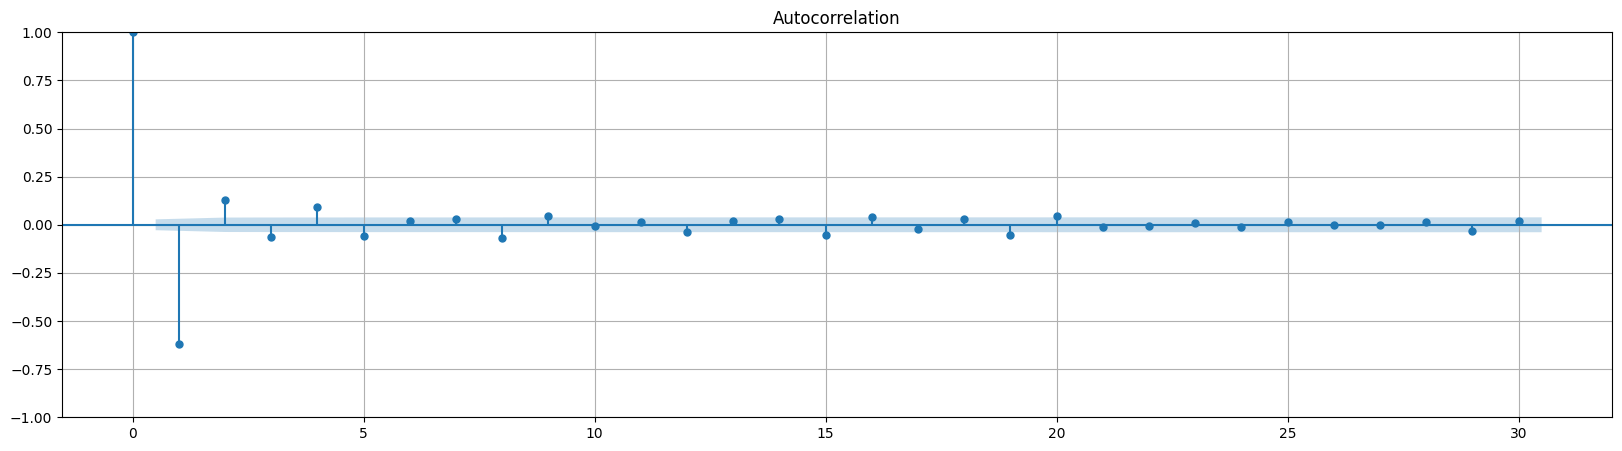

In [ ]:
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plt.figure(figsize=(20,5))
plt.grid()
plot_acf(diff3, ax=plt.gca(),lags=30)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
print("Result of Dickey Fuller Test")
dftest=adfuller(diff3)
dfoutput=pd.Series(dftest[0:4],index=["Test Statistic","p-value",'#Lags used','Number of Observation'])
for key,value in dftest[4].items():
    dfoutput['Critical Value(%s)' %key]= value
print(dfoutput)

Result of Dickey Fuller Test
Test Statistic            -28.433009
p-value                     0.000000
#Lags used                 32.000000
Number of Observation    4789.000000
Critical Value(1%)         -3.431716
Critical Value(5%)         -2.862144
Critical Value(10%)        -2.567091
dtype: float64


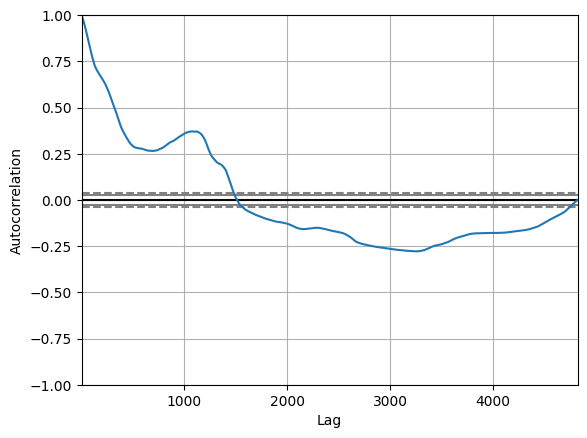

In [ ]:
autocorrelation_plot(df['Close'])
plt.show()

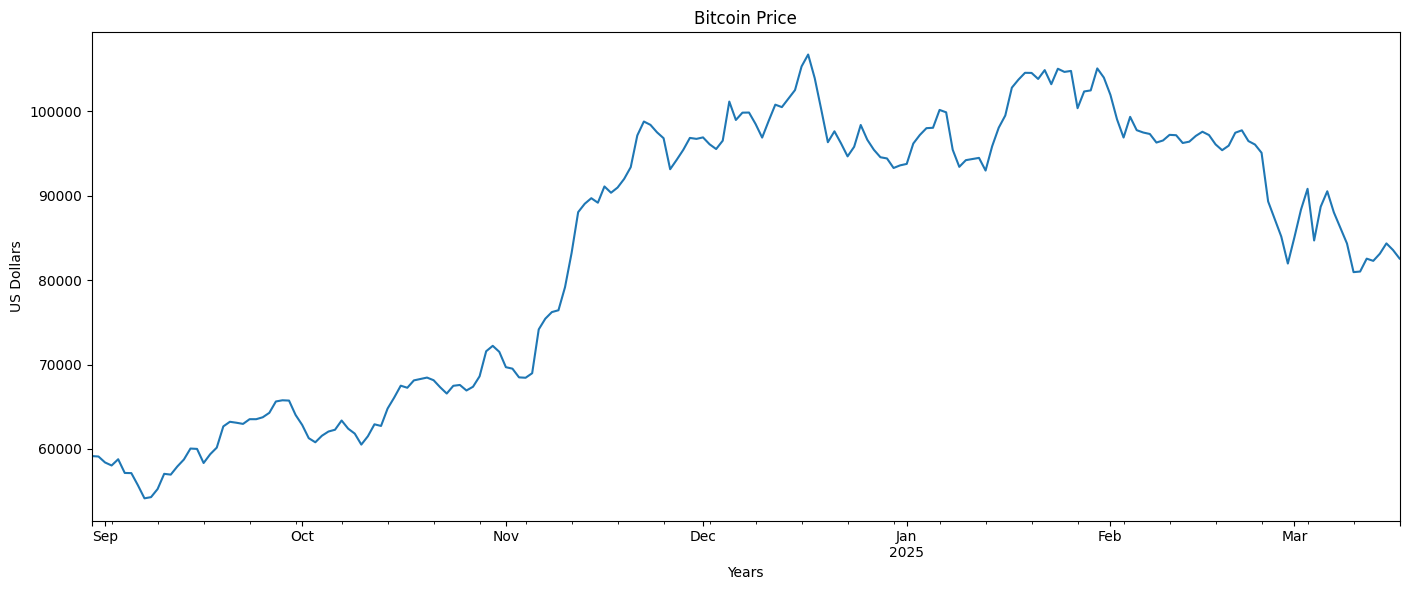

In [ ]:
# let's look at the past 200 days to possibly adjust our data to this period
df.Weighted_Price.iloc[-200:].plot(title = "Bitcoin Price", figsize=(14,6))
plt.tight_layout()
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.show()

In [ ]:
# Since the first couple years of bitcoin don't properly represent the movement and volatility of the price -
# We decide to simply focus on the previous 4 years of data from March 31st, 2021.
df2 = pd.read_csv('/content/btcusd_1-min_data.csv')
df2.Timestamp = pd.to_datetime(df2.Timestamp, unit='s')
df2.index = df2.Timestamp
# Exclude the 'Timestamp' column from resampling
# Explicitly selecting numeric columns for the mean calculation
numeric_cols = df2.select_dtypes(include=np.number).columns
df2 = df2[numeric_cols].resample('D').mean()
df2 = df2.dropna()
# changes data to strictly to the previous 4 years, which is March 2017 to March 2021
df2 = df2.iloc[(-365*4):]
print(df2.shape)

(1460, 5)


In [ ]:
df2["Weighted_Price"] = (df["Close"] * df["Volume"]) / df["Volume"]

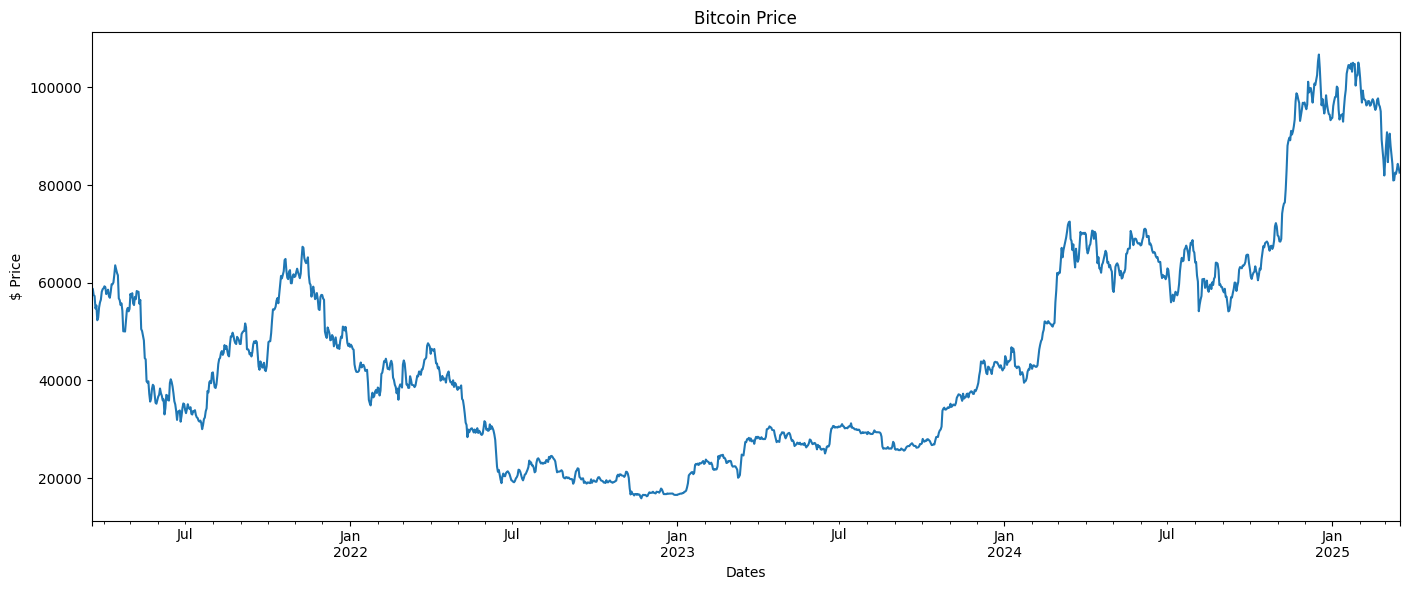

In [ ]:
df2.Weighted_Price.plot(title = "Bitcoin Price", figsize=(14,6))
plt.tight_layout()
plt.xlabel('Dates')
plt.ylabel('$ Price')
plt.show()
# This data looks much more relevant for training a model.
# However the recent spike will be involved in the testing data split - a tough prediction.

2. ARIMA MODEL

We first created a rolling forecast ARIMA model in order to get a baseline for what a great RMSE is. However, since this model predicts in rolling day by day increments, it isn't fair to compare to the other models. As plotted below, the predictions are in red and the actual prices are in blue. However, we have to zoom in more to distinguish the two.



In [ ]:
from statsmodels.tsa.arima.model import ARIMA
# We're going to create a dataframe for just the price (the index is still the date)
price = df2.Weighted_Price
# Next we're going to assign 70% percent of the data to training and 30% for testing
X = price.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

predicted=44267.735127, expected=43178.718750
predicted=43045.843499, expected=43881.518750
predicted=43975.016724, expected=43840.343750
predicted=43887.386571, expected=44050.809028
predicted=44073.602532, expected=44274.570139
predicted=44256.796664, expected=46787.113194
predicted=47091.580596, expected=45839.274306
predicted=45663.855508, expected=46541.943056
predicted=46638.355899, expected=45752.429167
predicted=45632.842318, expected=42922.334028
predicted=42684.820375, expected=42846.910417
predicted=42877.513377, expected=42519.225000
predicted=42517.121724, expected=42818.179861
predicted=42881.782395, expected=42829.615278
predicted=42758.823758, expected=42525.727083
predicted=42492.539453, expected=41145.731944
predicted=40982.062310, expected=41591.888194
predicted=41683.878827, expected=41683.203472
predicted=41691.447246, expected=41071.786111
predicted=41009.866059, expected=39526.649306
predicted=39324.602450, expected=39798.295139
predicted=39878.218986, expected=3

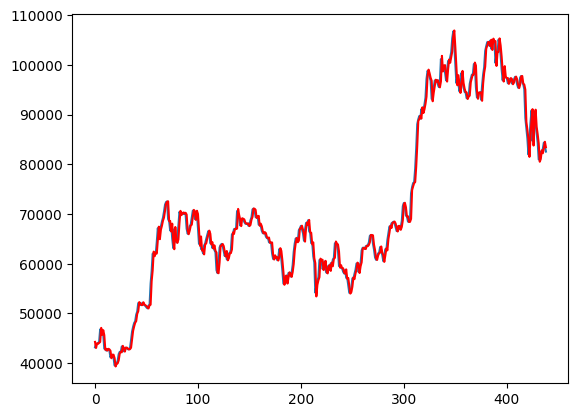

In [ ]:
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Test RMSE: 1547.962


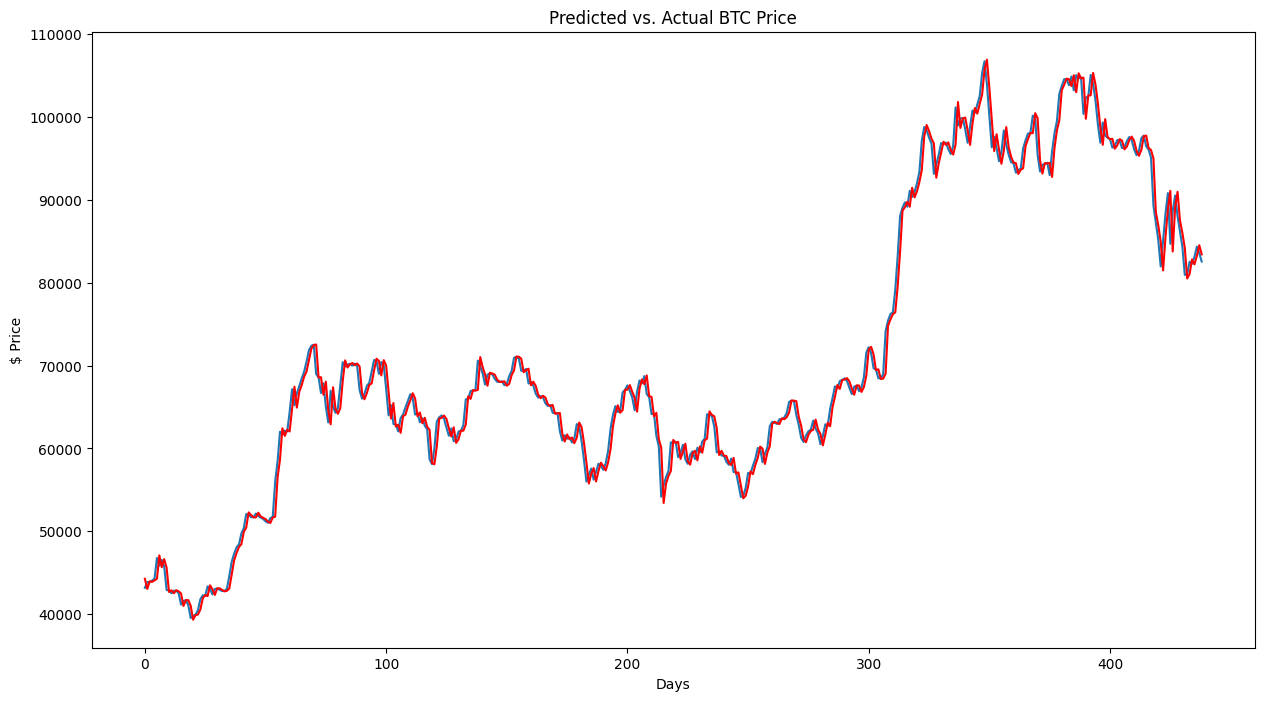

In [ ]:
# if we look at this model, the predicted is indistinuishable from the actual price
# this is simply because it's predicting day by day.
plt.figure(figsize=(15,8))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.xlabel('Days')
plt.ylabel('$ Price')
plt.title('Predicted vs. Actual BTC Price')
plt.show()

Test RMSE: 1547.962


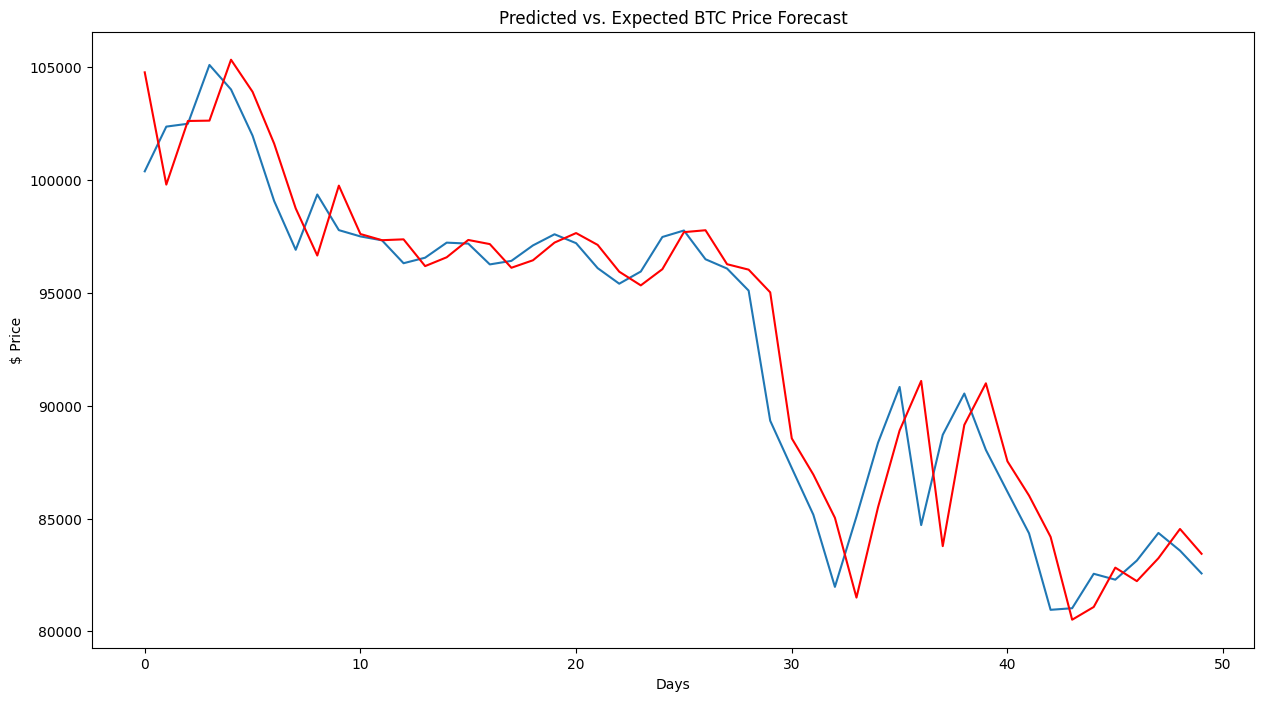

In [ ]:
# We plot 50 days to more accurately see how the models works with its lag
plt.figure(figsize=(15,8))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test[-50:])
plt.plot(predictions[-50:], color='red')
plt.xlabel('Days')
plt.ylabel('$ Price')
plt.title('Predicted vs. Expected BTC Price Forecast')
plt.show()

Next is ARIMA, an acronym that stands for AutoRegressive Integrated Moving Average. ARIMA is a widely used statistical method for analyzing and forecasting time series data. It consists of a suite of standard structures in time series data and provides a simple yet powerful method for making skillful time series forecasts. ARIMA models have 3 parameters (p, d, q), which indicate the specific ARIMA model being used. We simply applied parameters that I've used on different time series data in the past, which could've possibly led to an unfavorable model.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
# method to be used later
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i-interval]
        diff.append(value)
    return np.array(diff)

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [ ]:
print(len(test))

439


In [ ]:
# Split the data as usual 70, 30
price = df2.Weighted_Price
X = price.values
datesX = price.index
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
days_in_year = 365
plotDates = datesX[size:len(X)]

# Next we will forecast with ARIMA using 5,1,0
differenced = difference(train, days_in_year)
model = ARIMA(differenced, order=(5, 1, 0))
model_fit = model.fit()
start_index = len(differenced)
end_index = start_index + 438
forecast = model_fit.predict(start=start_index, end=end_index)

history = [x for x in train]
day = 1
predicted_results = list()

# store predicted results
for yhat in forecast:
    inverted = inverse_difference(history, yhat, days_in_year)
    print("Predicted Day %d: %f" % (day, inverted))
    history.append(inverted)
    predicted_results.append(inverted)
    day += 1


Predicted Day 1: 44370.167456
Predicted Day 2: 44326.840034
Predicted Day 3: 44381.010689
Predicted Day 4: 44468.148780
Predicted Day 5: 44473.345684
Predicted Day 6: 44715.745175
Predicted Day 7: 44781.594734
Predicted Day 8: 44964.888828
Predicted Day 9: 45610.612498
Predicted Day 10: 46461.591560
Predicted Day 11: 48090.215318
Predicted Day 12: 48321.194143
Predicted Day 13: 48504.190898
Predicted Day 14: 48718.337962
Predicted Day 15: 48763.787107
Predicted Day 16: 48334.541363
Predicted Day 17: 48613.309570
Predicted Day 18: 50226.801351
Predicted Day 19: 50443.910162
Predicted Day 20: 50310.466834
Predicted Day 21: 50506.975963
Predicted Day 22: 50215.625928
Predicted Day 23: 50603.609980
Predicted Day 24: 50517.138438
Predicted Day 25: 50593.250249
Predicted Day 26: 50814.932191
Predicted Day 27: 51028.881498
Predicted Day 28: 50435.798164
Predicted Day 29: 50603.242609
Predicted Day 30: 51326.941914
Predicted Day 31: 51078.169692
Predicted Day 32: 50922.129414
Predicted Day 33:

In [ ]:
rmse = np.sqrt(mean_squared_error(test, predicted_results))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 14919.687


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  656
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5644.192
Date:                Fri, 04 Apr 2025   AIC                          11300.384
Time:                        16:51:27   BIC                          11327.292
Sample:                             0   HQIC                         11310.817
                                - 656                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1910      0.034      5.700      0.000       0.125       0.257
ar.L2         -0.0108      0.037     -0.295      0.768      -0.083       0.061
ar.L3         -0.0277      0.038     -0.722      0.4

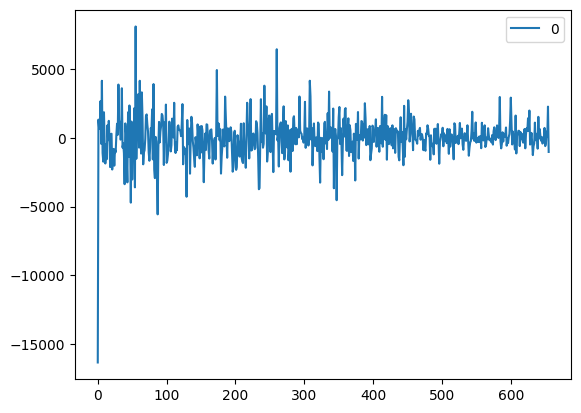

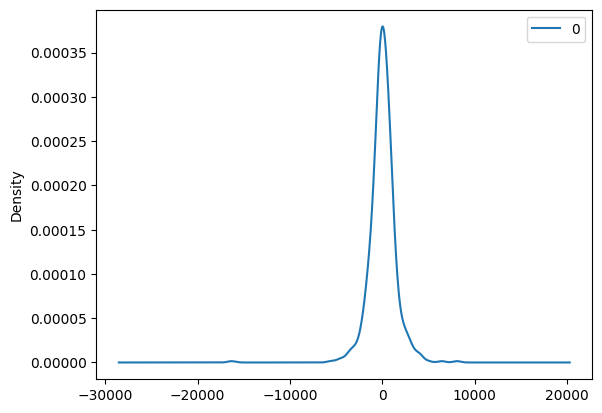

                  0
count    656.000000
mean      33.392448
std     1481.068174
min   -16332.279493
25%     -605.600318
50%       26.318425
75%      697.965582
max     8093.777971


In [ ]:
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

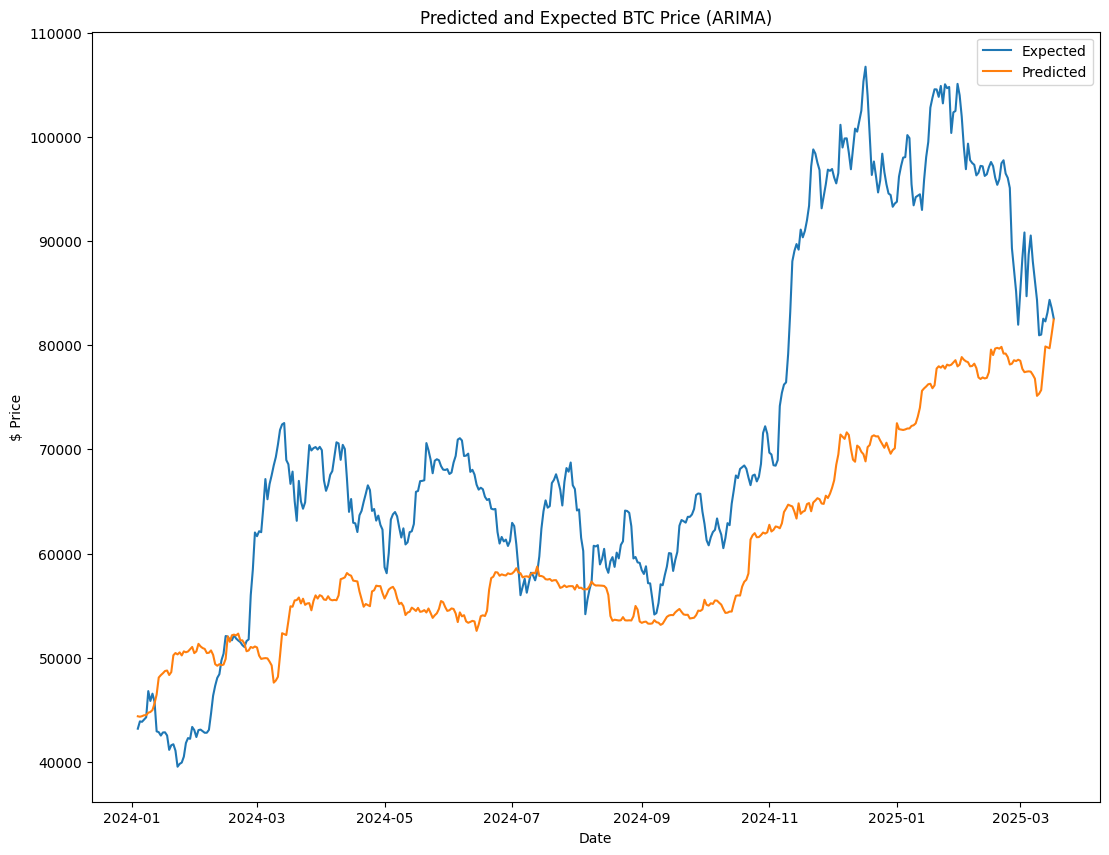

In [ ]:
plt.figure(figsize=(13,10))
plt.plot(plotDates, test, label='Expected')
plt.plot(plotDates, predicted_results, label='Predicted')
plt.ylabel('$ Price')
plt.xlabel('Date')
plt.legend(loc='best')
plt.title('Predicted and Expected BTC Price (ARIMA)')
plt.show()

3. LSTM
Long Short-Term Memory (LSTM) models are a type of recurrent neural network capable of learning sequences of observations. This makes them a deep learning network well suited for time series forecasting. However, usually a LTSM would struggle with a time series dataset as volatile and unpredictable as Bitcoin. After a grueling process of trying to apply my data, we finally trained the model. In my final fit we used 50 epochs and the “adam” optimizer.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Dropout,Flatten
from tensorflow.keras import Sequential
from statsmodels.graphics.tsaplots import plot_acf

In [ ]:
price = df2.Weighted_Price
# As usual split data, 70, 30
X = price
size = int(len(X) * 0.7)
train_df, test_df = X[0:size], X[size:len(X)]
training_values = train_df.values
training_values = np.reshape(training_values, (len(training_values), 1))

# Scale the data using minMaxScaler
scaler = MinMaxScaler()
training_values = scaler.fit_transform(training_values)
# assign training values
x_train = training_values[0: len(training_values)-1]
y_train = training_values[1: len(training_values)]
x_train = np.reshape(x_train, (len(x_train), 1, 1))

In [ ]:
# creates model
model = Sequential()
model.add(LSTM(10,input_shape = (None,1), activation="relu", return_sequences=True))
model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(loss="mean_squared_error",optimizer="adam")

In [ ]:
# fit the model to the training data
model.fit(x_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1363
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1076
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0817
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0617
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0402
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0313
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0258
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0224
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0220
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0184
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0179
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0158
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0139
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0126
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0115
Epoch 16/50
32/32 ━

In [ ]:
# assign test and predicted values + reshaping + converting back from scaler
test_values = test_df.values
test_values = np.reshape(test_values, (len(test_values), 1))
test_values = scaler.transform(test_values)
test_values = np.reshape(test_values, (len(test_values), 1, 1))
predicted_price = model.predict(test_values)
predicted_price = np.reshape(predicted_price, (len(predicted_price), 1))
predicted_price = scaler.inverse_transform(predicted_price)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


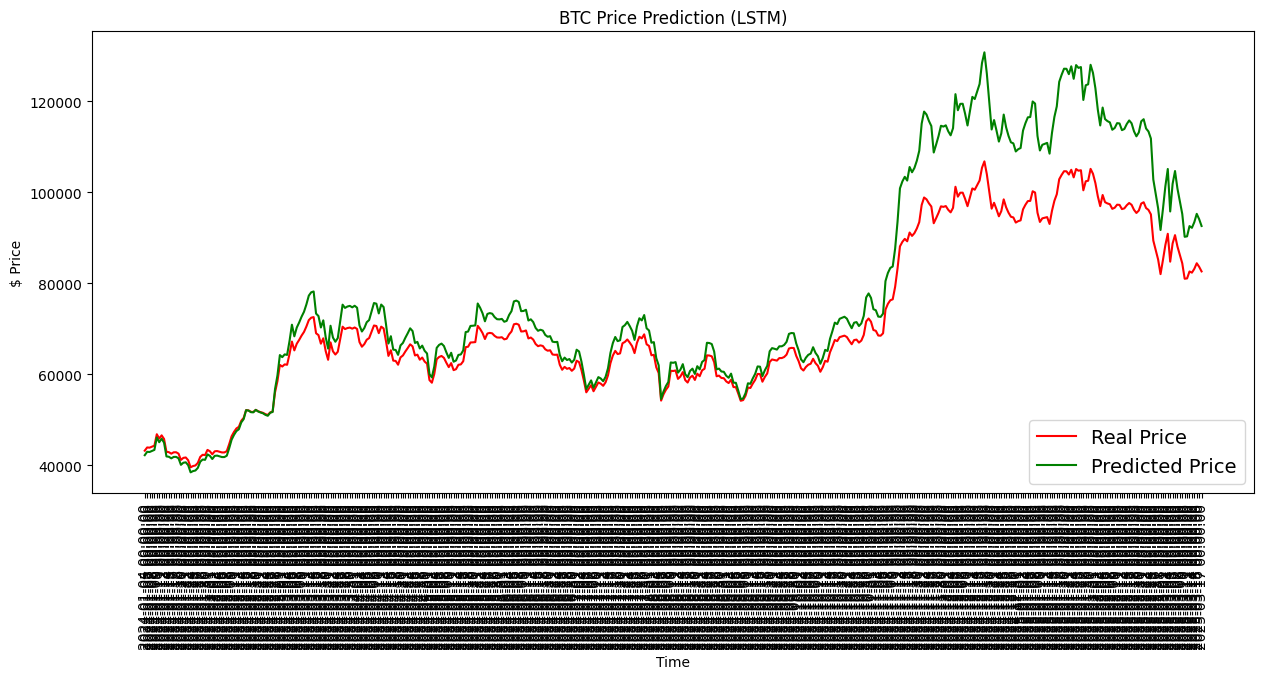

In [ ]:
# plotting the results
plt.figure(figsize=(15, 6))
ax = plt.gca()
plt.plot(test_df.values, color = 'red', label = 'Real Price')
plt.plot(predicted_price, color = 'green', label = 'Predicted Price')
plt.title('BTC Price Prediction (LSTM)')
test_df = test_df.reset_index()
x= test_df.index
labels = test_df['Timestamp']
plt.xticks(x, labels, rotation = 'vertical')
plt.xlabel('Time')
plt.ylabel('$ Price')
plt.legend(loc=4, prop={'size': 14})
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(test_df.Weighted_Price.values, predicted_price))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 9693.161


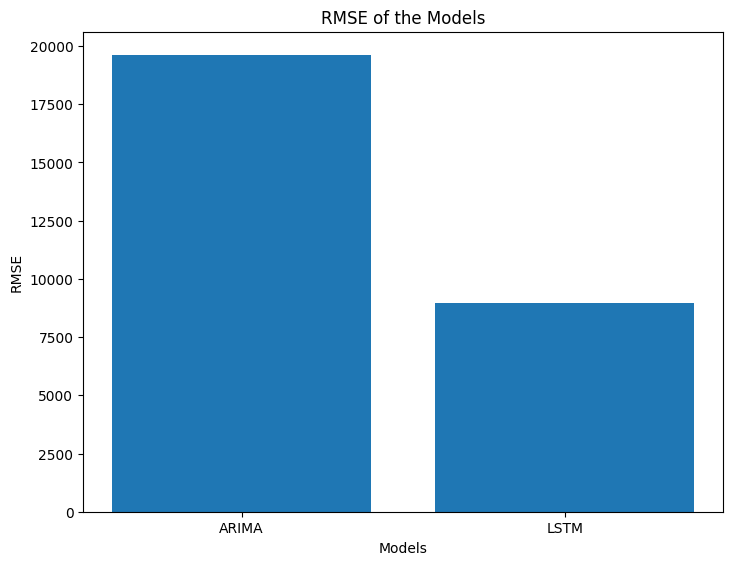

In [ ]:
# Final graph for the RMSE's of each model
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
modelz = ['ARIMA', 'LSTM']
nums = [19633,8950]
ax.bar(modelz,nums)
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE of the Models')
plt.show()
plt.show()

Conclusion
The **LSTM** model showed the best performance in predicting Bitcoin prices, despite the data being highly volatile and irregular.

We also recognize that some model parameters could have been better tuned for a fairer comparison. Still, the low RMSE achieved by LSTM highlights the strength of neural networks in handling complex time series forecasting tasks.